Carga de librerias

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


## Task 1

Carga de imagen periodic noise

In [5]:
imagen_periodic = cv2.imread("periodic_noise.jpg", cv2.IMREAD_GRAYSCALE)

Calculo de transformada de fourier discreta y shift en 0

In [8]:
imagen_f = imagen_periodic.astype(np.float32)

transformada_fourier = np.fft.fft2(imagen_f)

fourier_shift = np.fft.fftshift(transformada_fourier)

Calculo de versión logaritmica y grafica

In [10]:
magnitud = np.abs(fourier_shift)

logaritmica = np.log(1+magnitud)

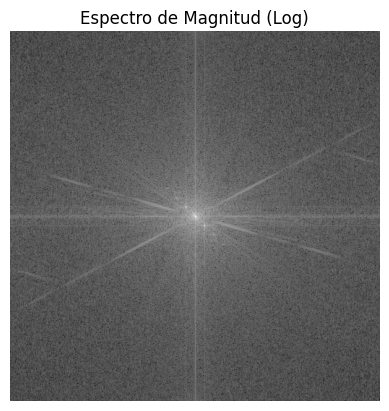

In [11]:
plt.imshow(logaritmica, cmap='gray')
plt.title("Espectro de Magnitud (Log)")
plt.axis('off')
plt.show()


In [79]:
def notch_lines_mask(shape, angles_deg, half_width=5, r_protect=12):

    H, W = shape
    cy, cx = H // 2, W // 2

    Y, X = np.ogrid[:H, :W]
    y = Y - cy
    x = X - cx

    # máscara inicial
    mask = np.ones((H, W), dtype=np.float32)

    r2 = x*x + y*y
    protect = r2 <= (r_protect * r_protect)

    for ang in angles_deg:
        theta = np.deg2rad(ang)

        dist = np.abs(x*np.sin(theta) - y*np.cos(theta))

        band = dist <= half_width

        mask[band & (~protect)] = 0.0

    mask[protect] = 1.0
    return mask


In [114]:
mask = notch_lines_mask(imagen_periodic.shape, angles_deg=[17, -28], half_width=2, r_protect=12)
F_filt = fourier_shift * mask


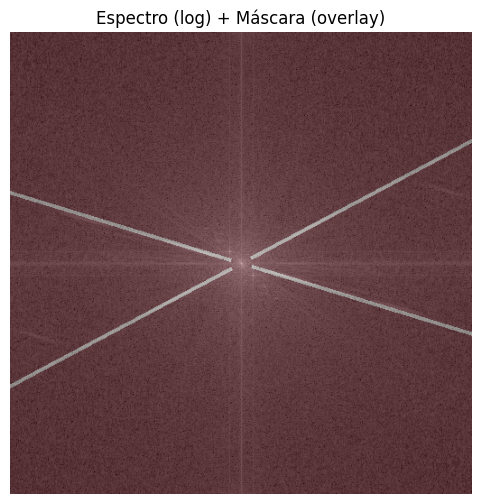

In [115]:
plt.figure(figsize=(6,6))
plt.imshow(logaritmica, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.35)  
plt.title("Espectro (log) + Máscara (overlay)")
plt.axis('off')
plt.show()


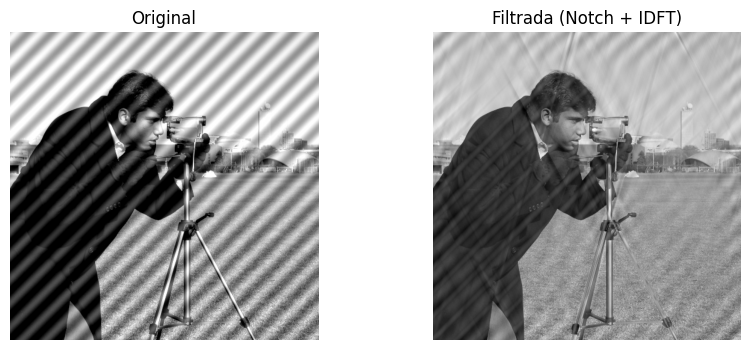

In [118]:

# 1) Filtrar en frecuencia (multiplicación punto a punto)
F_filt = fourier_shift * mask

# 2) Deshacer el shift y aplicar la inversa
F_ishift = np.fft.ifftshift(F_filt)
img_back = np.fft.ifft2(F_ishift)
img_back = np.real(img_back)   # quitar parte imaginaria pequeña por error numérico

# 3) Normalizar para visualizar (0-255) y convertir a uint8
img_out = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
img_out = img_out.astype(np.uint8)

# 4) Mostrar comparación
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(imagen_periodic, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_out, cmap='gray')
plt.title("Filtrada (Notch + IDFT)")
plt.axis('off')

plt.show()


In [87]:
import numpy as np

def add_notch_segments(mask, segments, half_width=1, r_protect=12):
    """
    Añade segmentos notch (mini-líneas) a una máscara existente.

    segments: lista de dicts con:
      {
        "angle_deg": 45,   # dirección de la línea (en grados)
        "r_min": 30,       # radio mínimo desde el centro
        "r_max": 90        # radio máximo desde el centro
      }

    half_width: grosor de la banda alrededor de la línea
    r_protect: protege el centro (no filtra dentro de este radio)
    """
    H, W = mask.shape
    cy, cx = H // 2, W // 2

    Y, X = np.ogrid[:H, :W]
    y = Y - cy
    x = X - cx

    r = np.sqrt(x*x + y*y)
    protect = r <= r_protect

    for seg in segments:
        theta = np.deg2rad(seg["angle_deg"])
        r_min, r_max = seg["r_min"], seg["r_max"]

        # distancia perpendicular a la línea que pasa por el centro con ángulo theta
        dist = np.abs(x*np.sin(theta) - y*np.cos(theta))

        band = dist <= half_width
        radial_window = (r >= r_min) & (r <= r_max)

        # bloquear solo donde coincide banda + ventana radial, sin tocar el centro
        mask[band & radial_window & (~protect)] = 0.0

    return mask


In [94]:
segments = [
    {"angle_deg": 35, "r_min": 35, "r_max": 200}
]

mask = add_notch_segments(mask, segments, half_width=3, r_protect=12)


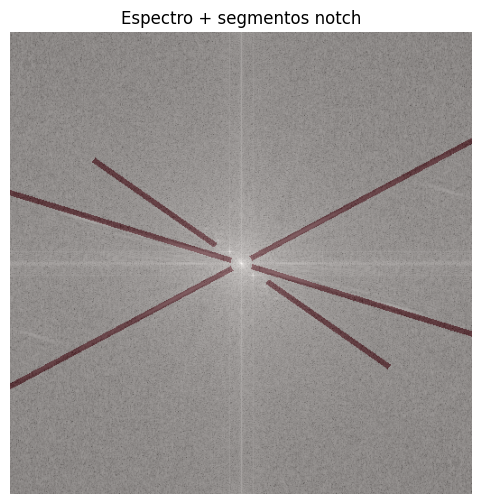

In [95]:
blocked = 1 - mask
plt.figure(figsize=(6,6))
plt.imshow(logaritmica, cmap='gray')
plt.imshow(blocked, cmap='Reds', alpha=0.35)
plt.title("Espectro + segmentos notch")
plt.axis('off')
plt.show()


In [72]:
def add_circular_notches(mask, centers, radius=4):
    """
    Añade notches circulares (pone a 0) en posiciones dadas.
    
    mask: máscara existente
    centers: lista de (y, x)
    radius: radio del notch
    """
    H, W = mask.shape
    Y, X = np.ogrid[:H, :W]

    for (cy, cx) in centers:
        circle = (Y - cy)**2 + (X - cx)**2 <= radius**2
        mask[circle] = 0.0

    return mask


In [116]:
H, W = imagen_periodic.shape
cy, cx = H // 2, W // 2

extra_peaks = [
    (cy - 14, cx - 14),
    (cy + 14, cx + 14),

]

mask = add_circular_notches(mask, extra_peaks, radius=3)


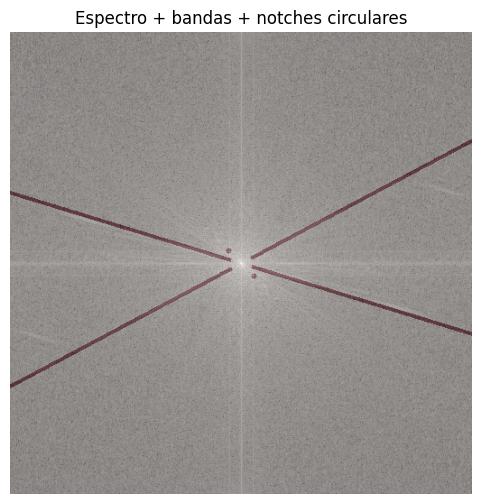

In [117]:
blocked = 1 - mask

plt.figure(figsize=(6,6))
plt.imshow(logaritmica, cmap='gray')
plt.imshow(blocked, cmap='Reds', alpha=0.35)
plt.title("Espectro + bandas + notches circulares")
plt.axis('off')
plt.show()
